# VAE for Speech Recognition using TIMIT  

The purpose of this demo is to help you learn about variational autoencoder. The algorithm is being implemented is from the paper "Auto-Encoding Variational Bayes", by Diederik P Kingma, Max Welling (https://arxiv.org/abs/1312.6114).

Followed the logic in https://github.com/ethanluoyc/pytorch-vae/blob/master/vae.py and https://github.com/jackjhliu/Pytorch-End-to-End-ASR-on-TIMIT.

We are using TIMIT data.

You are free to change model acrhitecture, or any part of the logic. 

If you have any suggestions or find errors, please, don't be hesitate to text me at jayanta.jayantamukherjee@gmail.com

In [1]:
import argparse
import build_model
import data
import eval_utils
import matplotlib.pyplot as plt
import os
from prepare_data import prepare_csv
from show_history import plotLearning
import time 
import torch
from torch import nn
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils
import torchvision
from torchvision import transforms
import torch.optim as optim
from train import train
import yaml

/home/jay/.conda/envs/jay/lib/python3.6/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


## Prepare Data from Raw WAV files: TIMIT


In [2]:
prepare_csv("../TIMIT/TIMIT_DATA/")

TRAIN.csv is created.
DEV.csv is created.
TEST.csv is created.
Data preparation is complete !


## MultiLayer GRUCell

In [3]:
class MultiLayerGRUCell(nn.Module):
    """
    Stack multiple GRU cells. For DecoderRNN.
    """
    def __init__(self, input_size, hidden_size, num_layers, drop_p):
        """
        Args:
            input_size (integer): Input size of GRU cells.
            hidden_size (integer): Hidden layer size of GRU cells.
            num_layers (integer): Number of GRU layers.
            drop_p (float): Probability to drop elements at Dropout layers.
        """
        super(MultiLayerGRUCell, self).__init__()

        self.cells = nn.ModuleList([])
        for i in range(num_layers):
            if i==0:
                self.cells.append(nn.GRUCell(input_size, hidden_size))
            else:
                self.cells.append(nn.GRUCell(hidden_size, hidden_size))
        self.dropouts = nn.ModuleList([nn.Dropout(drop_p) for _ in range(num_layers-1)])
        self.num_layers = num_layers

    def forward(self, x, h):
        """
        One step forward pass.
        
        Args:
            x (torch.FloatTensor, [batch_size, input_size]): The input features of current time step.
            h (torch.FloatTensor, [num_layers, batch_size, hidden_size]): The hidden state of previous time step.
            
        Returns:
            outputs (torch.FloatTensor, [num_layers, batch_size, hidden_size]): The hidden state of current time step.
        """
        outputs = []
        for i in range(self.num_layers):
            if i==0:
                x = self.cells[i](x, h[i])
            else:
                x = self.cells[i](self.dropouts[i-1](x), h[i])
            outputs.append(x)
        outputs = torch.stack(outputs, dim=0)
        return outputs

#### Load Config & Clean up Previous Run Stats

In [4]:
cfgFile = "config/default.yaml" 
import shutil

with open(cfgFile) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
        
if not cfg['logdir']:
    save_path = os.path.splitext(cfgFile)[0]
    
if os.path.exists(save_path):
    shutil.rmtree(save_path)

os.mkdir(save_path)

In [5]:
gpu_id = 0
workers = 0
ckpt_freq = 10

#train(cfg, save_path, gpu_id, workers, ckpt_freq)

### Encoder  RNN

D_in: Input Dimension
H: 
D_out: Output Dimension

In [6]:
class EncoderRNN(nn.Module):
    """
    A bidirectional RNN. It takes FBANK features and outputs the output state vectors of every time step.
    """
    def __init__(self, hidden_size, num_layers, drop_p):
        """
        Args:
            hidden_size (integer): Size of GRU cells.
            num_layers (integer): Number of GRU layers.
            drop_p (float): Probability to drop elements at Dropout layers.
        """
        super(EncoderRNN, self).__init__()
        self.embed = nn.Linear(240, hidden_size)   # 240 is the dimension of acoustic features.
        self.rnn = nn.GRU(hidden_size,
                          hidden_size,
                          batch_first=True,
                          bidirectional=True,
                          num_layers=num_layers,
                          dropout=drop_p)
        # The initial state is a trainable vector.
        self.init_state = torch.nn.Parameter(torch.randn([2 * num_layers, 1, hidden_size]))

    def forward(self, xs, xlens):
        """
        We pack the padded sequences because it is especially important for bidirectional RNN to work properly. The RNN 
        in opposite direction can ignore the first few <PAD> tokens after packing.

        Args:
            xs (torch.FloatTensor, [batch_size, seq_length, dim_features]): A mini-batch of FBANK features.
            xlens (torch.LongTensor, [batch_size]): Sequence lengths before padding.

        Returns:
            outputs (PackedSequence): The packed output states.
        """
        #print("EncoderRNN forward")
        batch_size = xs.shape[0]
        xs = self.embed(xs)
        xs = rnn_utils.pack_padded_sequence(xs,
                                            xlens,
                                            batch_first=True,
                                            enforce_sorted=False)
        outputs, _ = self.rnn(xs, self.init_state.repeat([1, batch_size, 1]))
        #print("EncoderRNN outputs = ", outputs)
        return outputs

### Decoder RNN

In [7]:
class DecoderRNN(nn.Module):
    """
    A decoder network which applies Luong attention (https://arxiv.org/abs/1508.04025).
    """
    def __init__(self, n_words, hidden_size, num_layers, drop_p):
        """
        Args:
            n_words (integer): Size of the target vocabulary.
            hidden_size (integer): Size of GRU cells.
            num_layers (integer): Number of GRU layers.
            drop_p (float): Probability to drop elements at Dropout layers.
        """
        super(DecoderRNN, self).__init__()

        self.hidden_size = hidden_size
        self.embed = nn.Embedding(n_words, hidden_size)
        self.cell = MultiLayerGRUCell(2 * hidden_size,
                                      hidden_size,
                                      num_layers=num_layers,
                                      drop_p=drop_p)
        # The initial states are trainable vectors.
        self.init_h = torch.nn.Parameter(torch.randn([num_layers, 1, hidden_size]))
        self.init_y = torch.nn.Parameter(torch.randn([1, hidden_size]))

        self.attn_W = nn.Linear(2 * hidden_size, hidden_size)
        self.attn_U = nn.Linear(hidden_size, hidden_size)
        self.attn_v = nn.Linear(hidden_size, 1)
        self.fc = nn.Linear(3 * hidden_size, hidden_size)
        self.drop = nn.Dropout(drop_p)
        self.classifier = nn.Linear(hidden_size, n_words)

    def forward(self, encoder_states, ground_truths=None):
        """
        The forwarding behavior depends on if ground-truths are provided.

        Args:
            encoder_states (PackedSequence): Packed output state vectors from the EncoderRNN.
            ground_truths (torch.LongTensor, [batch_size, padded_len_tgt]): Padded ground-truths.

        Returns:
            * When ground-truths are provided, it returns cross-entropy loss. Otherwise it returns predicted word IDs
            and the attention weights.
            loss (float): The cross-entropy loss to maximizing the probability of generating ground-truths.
            predictions (torch.FloatTensor, [batch_size, max_length]): The sentence generated by Greedy Search.
            all_attn_weights (torch.FloatTensor, [batch_size, max_length, length_of_encoder_states]): A list contains
                attention alignment weights for the predictions.
        """
        #print("DecoderRNN forward")
        states, states_lengths  = rnn_utils.pad_packed_sequence(
            encoder_states, batch_first=True)   # [batch_size, padded_len_src, 2 * hidden_size], [batch_size]
        batch_size = states.shape[0]
        h = self.init_h.repeat([1, batch_size, 1])   # [num_layers, batch_size, hidden_size]
        y = self.init_y.repeat([batch_size, 1])      # [batch_size, hidden_size]

        if ground_truths is None:
            all_attn_weights = []
            predictions = [torch.full([batch_size], 3, dtype=torch.int64).cuda()]   # The first predicted word is always <s> (ID=3).
            # Unrolling the forward pass
            for time_step in range(100):   # Empirically set max_length=100
                x = predictions[-1]                           # [batch_size]
                x = self.embed(x)                             # [batch_size, hidden_size]
                h = self.cell(torch.cat([y, x], dim=-1), h)   # [num_layers, batch_size, hidden_size]
                attns, attn_weights = self.apply_attn(
                    states, states_lengths, h[-1])            # [batch_size, 2 * hidden_size], [batch_size, length_of_encoder_states]
                y = torch.cat([attns, h[-1]], dim=-1)         # [batch_size, 3 * hidden_size]
                y = F.relu(self.fc(y))                        # [batch_size, hidden_size]

                all_attn_weights.append(attn_weights)
                # Output
                logits = self.classifier(y)                   # [batch_size, n_words]
                # TODO: Adopt Beam Search to replace Greedy Search
                samples = torch.argmax(logits, dim=-1)        # [batch_size]
                predictions.append(samples)
            all_attn_weights = torch.stack(all_attn_weights, dim=1)   # [batch_size, max_length, length_of_encoder_states]
            predictions = torch.stack(predictions, dim=-1)    # [batch_size, max_length]
            #print("DecoderRNN predictions = ", predictions)
            return predictions, all_attn_weights
        else:
            xs = self.embed(ground_truths[:, :-1])   # [batch_size, padded_len_tgt, hidden_size]
            outputs = []
            # Unrolling the forward pass
            for time_step in range(xs.shape[1]):
                h = self.cell(torch.cat([y, xs[:,time_step]], dim=-1), h)   # [num_layers, batch_size, hidden_size]
                attns, _ = self.apply_attn(states, states_lengths, h[-1])       # [batch_size, 2 * hidden_size]
                y = torch.cat([attns, h[-1]], dim=-1)                           # [batch_size, 3 * hidden_size]
                y = F.relu(self.fc(y))                                          # [batch_size, hidden_size]
                outputs.append(y)

            # Output
            outputs = torch.stack(outputs, dim=1)   # [batch_size, padded_len_tgt, hidden_size]
            outputs = self.drop(outputs)
            outputs = self.classifier(outputs)      # [batch_size, padded_len_tgt, n_words]
            #print("DecoderRNN outputs = ", outputs)
            

            # Compute loss
            mask = ground_truths[:, 1:].gt(0)       # [batch_size, padded_len_tgt]
            loss = nn.CrossEntropyLoss()(outputs[mask], ground_truths[:, 1:][mask])
            return loss

    def apply_attn(self, source_states, source_lengths, target_states):
        """
        Apply attention.

        Args:
            source_states (torch.FloatTensor, [batch_size, padded_length_of_encoder_states, 2 * hidden_size]):
                The padded encoder output states.
            source_lengths (torch.LongTensor, [batch_size]): The length of encoder output states before padding.
            target_state (torch.FloatTensor, [batch_size, hidden_size]): The decoder output state (of previous time step).

        Returns:
            attns (torch.FloatTensor, [batch_size, hidden_size]):
                The attention result (weighted sum of Encoder output states).
            attn_weights (torch.FloatTensor, [batch_size, padded_length_of_encoder_states]): The attention alignment weights.
        """
        # A two-layer network used for project every pair of [source_state, target_state].
        attns = self.attn_W(source_states) + self.attn_U(target_states).unsqueeze(1)   # [batch_size, padded_len_src, hidden_size]
        attns = self.attn_v(F.relu(attns)).squeeze(2)                   # [batch_size, padded_len_src]

        # Create a mask with shape [batch_size, padded_len_src] to ignore the encoder states with <PAD> tokens.
        mask = torch.arange(attns.shape[1]).unsqueeze(0).repeat([attns.shape[0], 1]).ge(source_lengths.unsqueeze(1))
        attns = attns.masked_fill_(mask.cuda(), -float('inf'))          # [batch_size, padded_len_src]
        attns = F.softmax(attns, dim=-1)                                # [batch_size, padded_len_src]
        attn_weights = attns.clone()
        attns = torch.sum(source_states * attns.unsqueeze(-1), dim=1)   # [batch_size, 2 * hidden_size]
        return attns, attn_weights

## VAE Models 

In [8]:
class VAE(torch.nn.Module):
    """
    Sequence-to-sequence model at high-level view. It is made up of an EncoderRNN module and a DecoderRNN module.
    """
    def __init__(self, target_size, hidden_size, encoder_layers, decoder_layers, drop_p=0.):
        """
        Args:
            target_size (integer): Target vocabulary size.
            hidden_size (integer): Size of GRU cells.
            encoder_layers (integer): EncoderRNN layers.
            decoder_layers (integer): DecoderRNN layers.
            drop_p (float): Probability to drop elements at Dropout layers.
        """
        super(VAE, self).__init__()
        print("Init VAE")

        self.encoder = EncoderRNN(hidden_size, encoder_layers, drop_p)
        self.decoder = DecoderRNN(target_size, hidden_size, decoder_layers, drop_p)

    def forward(self, xs, xlens, ys=None):
        """
        The forwarding behavior depends on if ground-truths are provided.

        Args:
            xs (torch.LongTensor, [batch_size, seq_length, dim_features]): A mini-batch of FBANK features.
            xlens (torch.LongTensor, [batch_size]): Sequence lengths before padding.
            ys (torch.LongTensor, [batch_size, padded_length_of_target_sentences]): Padded ground-truths.

        Returns:
            * When ground-truths are provided, it returns cross-entropy loss. Otherwise it returns predicted word IDs
            and the attention weights.
            loss (float): The cross-entropy loss to maximizing the probability of generating ground-truth.
            predictions (torch.FloatTensor, [batch_size, max_length]): The sentence generated by Greedy Search.
            attn_weights (torch.FloatTensor, [batch_size, max_length, length_of_encoder_states]): A list contains
                attention alignment weights for the predictions.
        """
        #print("VAE forward")
        if ys is None:
            predictions, attn_weights = self.decoder(self.encoder(xs, xlens))
            return predictions, attn_weights
        else:
            loss = self.decoder(self.encoder(xs, xlens), ys)
            return loss

In [9]:
#### Auxiliary Methods to support train

In [10]:
def get_lr(optimizer):
    """
    A helper function to retrieve the solver's learning rate.
    """
    for param_group in optimizer.param_groups:
        return param_group['lr']


def log_history(save_path, message):
    """
    A helper function to log the history.
    The history text file is saved as: {SAVE_PATH}/history.txt

    Args:
        save_path (string): The location to log the history.
        message (string): The message to log.
    """
    fname = os.path.join(save_path,'history.csv')
    if not os.path.exists(fname):
        with open(fname, 'w') as f:
            f.write("datetime,epoch,learning rate,train loss,dev loss,error rate\n")
            f.write("%s\n" % message)
    else:
        with open(fname, 'a') as f:
            f.write("%s\n" % message)


def save_checkpoint(filename, save_path, epoch, dev_error, cfg, weights):
    """
    Args:
        filename (string): Filename of this checkpoint.
        save_path (string): The location to save.
        epoch (integer): Epoch number.
        dev_error (float): Error rate on development set.
        cfg (dict): Experiment config for reconstruction.
        weights (dict): "state_dict" of this model.
    """
    filename = os.path.join(save_path, filename)
    info = {'epoch': epoch,
            'dev_error': dev_error,
            'cfg': cfg,
            'weights': weights}
    torch.save(info, filename)

## Initialize VAE Model

In [11]:
input_dim = 100
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
assert torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = cfg['train']['batch_size']
#transform = transforms.Compose([transforms.ToTensor()])

# Create dataset
train_loader = data.load(split='train', batch_size=batch_size, workers = workers)
dev_loader = data.load(split='dev', batch_size=batch_size)

# Build model
tokenizer = torch.load('tokenizer.pth')
model = VAE(len(tokenizer.vocab),
            hidden_size=cfg['model']['hidden_size'],
            encoder_layers=cfg['model']['encoder_layers'],
            decoder_layers=cfg['model']['decoder_layers'],
            drop_p=cfg['model']['drop_p'])
model = model.cuda() 

TRAIN set size: 3696
DEV set size: 1152
Init VAE


### Train the VAE

In [12]:
# Training criteria
optimizer = torch.optim.Adam(model.parameters(), lr=cfg['train']['init_lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode='min',
                                                       factor=cfg['train']['decay_factor'],
                                                       patience=cfg['train']['patience'],
                                                       min_lr=1e-6)


RMS = []
train_epoch_durations = []
eval_epoch_durations = []

best_epoch = 0
best_error = float('inf')
for epoch in range(cfg['train']['epochs'] + 1):
    print ("---")
    # Show learning rate
    lr = get_lr(optimizer)
    print("Learning rate: %f" % lr)
    ssqrtm = eval_utils.get_error(train_loader, model)
    RMS.append(ssqrtm)

    start_train = time.time()
    # Training loop
    model.train()
    end_train = time.time()
    train_loss = 0
    n_tokens = 0
    for step, (xs, xlens, ys) in enumerate(train_loader):
        start_train_epoch = time.time()
        loss = model(xs.cuda(), xlens, ys.cuda())
        train_loss += loss.item() * (ys[:,1:] > 0).long().sum()
        n_tokens += (ys[:,1:] > 0).long().sum()

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.)   # Gradient clipping
        optimizer.step()

        if not step%10:
            print (time.strftime("%H:%M:%S", time.localtime()), end=' ')
            print ("epoch: %d, step: %d, loss: %.3f RMSE: %.3f" % (epoch, step, loss.item(), np.round(RMS[-1], 6)))
            #print("tr(Cov): {}".format(np.round(trcov[-1], 6)))
    train_loss = train_loss / n_tokens
    end_train_epoch = time.time()
    train_epoch_duration = end_train_epoch - start_train_epoch
    train_epoch_durations.append(train_epoch_duration)

    # Validation loop
    model.eval()
    # Compute dev loss
    dev_loss = 0
    n_tokens = 0
    with torch.no_grad():
        for (xs, xlens, ys) in dev_loader:
            dev_loss += model(xs.cuda(), xlens, ys.cuda()).item() * (ys[:,1:] > 0).long().sum()
            n_tokens += (ys[:,1:] > 0).long().sum()
    dev_loss = dev_loss / n_tokens
    # Compute dev error rate
    error = eval_utils.get_error(dev_loader, model)
    print ("Dev. loss: %.3f," % dev_loss, end=' ')
    print ("dev. error rate: %.4f" % error)
    if error < best_error:
        best_error = error
        best_epoch = epoch
        # Save best model
        save_checkpoint("best.pth", save_path, best_epoch, best_error, cfg, model.state_dict())
    print ("Best dev. error rate: %.4f @epoch: %d" % (best_error, best_epoch))

    scheduler.step(error)

    # Save checkpoint
    if not epoch%ckpt_freq or epoch==cfg['train']['epochs']:
        save_checkpoint("checkpoint_%05d.pth"%epoch, save_path, epoch, error, cfg, model.state_dict())

    # Logging
    datetime = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
    msg = "%s,%d,%f,%f,%f,%f" % (datetime, epoch, lr, train_loss, dev_loss, error)
    log_history(save_path, msg)
    end_eval_epoch = time.time()
    eval_epoch_duration = end_eval_epoch - end_train_epoch
    eval_epoch_durations.append(eval_epoch_duration) 

---
Learning rate: 0.000300


/home/jay/.conda/envs/jay/lib/python3.6/site-packages/torchaudio/compliance/kaldi.py:574: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  fft = torch.rfft(strided_input, 1, normalized=False, onesided=True)


Calculating error rate ... (#batch: 58/58)
15:50:33 epoch: 0, step: 0, loss: 4.188 RMSE: 1.028
15:50:37 epoch: 0, step: 10, loss: 3.950 RMSE: 1.028
15:50:42 epoch: 0, step: 20, loss: 3.910 RMSE: 1.028
15:50:47 epoch: 0, step: 30, loss: 3.833 RMSE: 1.028
15:50:52 epoch: 0, step: 40, loss: 3.704 RMSE: 1.028
15:50:56 epoch: 0, step: 50, loss: 3.556 RMSE: 1.028
Calculating error rate ... (#batch: 18/18)
Dev. loss: 3.351, dev. error rate: 2.2881
Best dev. error rate: 2.2881 @epoch: 0
---
Learning rate: 0.000300
Calculating error rate ... (#batch: 58/58)
15:51:30 epoch: 1, step: 0, loss: 3.398 RMSE: 2.265
15:51:35 epoch: 1, step: 10, loss: 3.273 RMSE: 2.265
15:51:40 epoch: 1, step: 20, loss: 3.166 RMSE: 2.265
15:51:44 epoch: 1, step: 30, loss: 3.065 RMSE: 2.265
15:51:49 epoch: 1, step: 40, loss: 3.033 RMSE: 2.265
15:51:54 epoch: 1, step: 50, loss: 3.081 RMSE: 2.265
Calculating error rate ... (#batch: 18/18)
Dev. loss: 2.891, dev. error rate: 2.2881
Best dev. error rate: 2.2881 @epoch: 0
---


Calculating error rate ... (#batch: 58/58)
16:05:54 epoch: 16, step: 0, loss: 2.475 RMSE: 0.732
16:05:59 epoch: 16, step: 10, loss: 2.372 RMSE: 0.732
16:06:03 epoch: 16, step: 20, loss: 2.386 RMSE: 0.732
16:06:08 epoch: 16, step: 30, loss: 2.335 RMSE: 0.732
16:06:13 epoch: 16, step: 40, loss: 2.369 RMSE: 0.732
16:06:18 epoch: 16, step: 50, loss: 2.328 RMSE: 0.732
Calculating error rate ... (#batch: 18/18)
Dev. loss: 2.404, dev. error rate: 0.7211
Best dev. error rate: 0.7211 @epoch: 16
---
Learning rate: 0.000150
Calculating error rate ... (#batch: 58/58)
16:06:51 epoch: 17, step: 0, loss: 2.338 RMSE: 0.711
16:06:56 epoch: 17, step: 10, loss: 2.298 RMSE: 0.711
16:07:01 epoch: 17, step: 20, loss: 2.370 RMSE: 0.711
16:07:06 epoch: 17, step: 30, loss: 2.317 RMSE: 0.711
16:07:11 epoch: 17, step: 40, loss: 2.272 RMSE: 0.711
16:07:15 epoch: 17, step: 50, loss: 2.296 RMSE: 0.711
Calculating error rate ... (#batch: 18/18)
Dev. loss: 2.277, dev. error rate: 0.7279
Best dev. error rate: 0.7211 @

Calculating error rate ... (#batch: 18/18)
Dev. loss: 1.335, dev. error rate: 0.4465
Best dev. error rate: 0.4465 @epoch: 31
---
Learning rate: 0.000150
Calculating error rate ... (#batch: 58/58)
16:21:15 epoch: 32, step: 0, loss: 1.390 RMSE: 0.414
16:21:20 epoch: 32, step: 10, loss: 1.315 RMSE: 0.414
16:21:25 epoch: 32, step: 20, loss: 1.317 RMSE: 0.414
16:21:30 epoch: 32, step: 30, loss: 1.289 RMSE: 0.414
16:21:35 epoch: 32, step: 40, loss: 1.390 RMSE: 0.414
16:21:40 epoch: 32, step: 50, loss: 1.249 RMSE: 0.414
Calculating error rate ... (#batch: 18/18)
Dev. loss: 1.246, dev. error rate: 0.4309
Best dev. error rate: 0.4309 @epoch: 32
---
Learning rate: 0.000150
Calculating error rate ... (#batch: 58/58)
16:22:13 epoch: 33, step: 0, loss: 1.293 RMSE: 0.397
16:22:18 epoch: 33, step: 10, loss: 1.284 RMSE: 0.397
16:22:23 epoch: 33, step: 20, loss: 1.254 RMSE: 0.397
16:22:27 epoch: 33, step: 30, loss: 1.276 RMSE: 0.397
16:22:32 epoch: 33, step: 40, loss: 1.245 RMSE: 0.397
16:22:37 epoch: 

16:36:00 epoch: 47, step: 40, loss: 0.908 RMSE: 0.269
16:36:05 epoch: 47, step: 50, loss: 0.953 RMSE: 0.269
Calculating error rate ... (#batch: 18/18)
Dev. loss: 0.951, dev. error rate: 0.3150
Best dev. error rate: 0.3150 @epoch: 47
---
Learning rate: 0.000150
Calculating error rate ... (#batch: 58/58)
16:36:39 epoch: 48, step: 0, loss: 0.971 RMSE: 0.264
16:36:44 epoch: 48, step: 10, loss: 0.921 RMSE: 0.264
16:36:49 epoch: 48, step: 20, loss: 0.902 RMSE: 0.264
16:36:53 epoch: 48, step: 30, loss: 0.908 RMSE: 0.264
16:36:58 epoch: 48, step: 40, loss: 0.916 RMSE: 0.264
16:37:03 epoch: 48, step: 50, loss: 0.952 RMSE: 0.264
Calculating error rate ... (#batch: 18/18)
Dev. loss: 0.955, dev. error rate: 0.3155
Best dev. error rate: 0.3150 @epoch: 47
---
Learning rate: 0.000150
Calculating error rate ... (#batch: 58/58)
16:37:37 epoch: 49, step: 0, loss: 0.953 RMSE: 0.262
16:37:42 epoch: 49, step: 10, loss: 0.916 RMSE: 0.262
16:37:46 epoch: 49, step: 20, loss: 0.936 RMSE: 0.262
16:37:51 epoch: 

16:51:27 epoch: 63, step: 20, loss: 0.761 RMSE: 0.203
16:51:32 epoch: 63, step: 30, loss: 0.797 RMSE: 0.203
16:51:37 epoch: 63, step: 40, loss: 0.833 RMSE: 0.203
16:51:42 epoch: 63, step: 50, loss: 0.754 RMSE: 0.203
Calculating error rate ... (#batch: 18/18)
Dev. loss: 0.819, dev. error rate: 0.2749
Best dev. error rate: 0.2749 @epoch: 63
---
Learning rate: 0.000150
Calculating error rate ... (#batch: 58/58)
16:52:16 epoch: 64, step: 0, loss: 0.724 RMSE: 0.201
16:52:21 epoch: 64, step: 10, loss: 0.745 RMSE: 0.201
16:52:26 epoch: 64, step: 20, loss: 0.766 RMSE: 0.201
16:52:31 epoch: 64, step: 30, loss: 0.743 RMSE: 0.201
16:52:36 epoch: 64, step: 40, loss: 0.779 RMSE: 0.201
16:52:40 epoch: 64, step: 50, loss: 0.719 RMSE: 0.201
Calculating error rate ... (#batch: 18/18)
Dev. loss: 0.850, dev. error rate: 0.2736
Best dev. error rate: 0.2736 @epoch: 64
---
Learning rate: 0.000150
Calculating error rate ... (#batch: 58/58)
16:53:15 epoch: 65, step: 0, loss: 0.736 RMSE: 0.200
16:53:20 epoch: 

Calculating error rate ... (#batch: 58/58)
17:06:29 epoch: 79, step: 0, loss: 0.601 RMSE: 0.162
17:06:33 epoch: 79, step: 10, loss: 0.591 RMSE: 0.162
17:06:38 epoch: 79, step: 20, loss: 0.605 RMSE: 0.162
17:06:43 epoch: 79, step: 30, loss: 0.648 RMSE: 0.162
17:06:47 epoch: 79, step: 40, loss: 0.607 RMSE: 0.162
17:06:52 epoch: 79, step: 50, loss: 0.603 RMSE: 0.162
Calculating error rate ... (#batch: 18/18)
Dev. loss: 0.779, dev. error rate: 0.2536
Best dev. error rate: 0.2536 @epoch: 79
---
Learning rate: 0.000150
Calculating error rate ... (#batch: 58/58)
17:07:24 epoch: 80, step: 0, loss: 0.606 RMSE: 0.158
17:07:29 epoch: 80, step: 10, loss: 0.563 RMSE: 0.158
17:07:34 epoch: 80, step: 20, loss: 0.588 RMSE: 0.158
17:07:38 epoch: 80, step: 30, loss: 0.594 RMSE: 0.158
17:07:43 epoch: 80, step: 40, loss: 0.601 RMSE: 0.158
17:07:48 epoch: 80, step: 50, loss: 0.596 RMSE: 0.158
Calculating error rate ... (#batch: 18/18)
Dev. loss: 0.801, dev. error rate: 0.2556
Best dev. error rate: 0.2536 @

Calculating error rate ... (#batch: 18/18)
Dev. loss: 0.783, dev. error rate: 0.2475
Best dev. error rate: 0.2475 @epoch: 94
---
Learning rate: 0.000150
Calculating error rate ... (#batch: 58/58)
17:21:20 epoch: 95, step: 0, loss: 0.483 RMSE: 0.132
17:21:25 epoch: 95, step: 10, loss: 0.526 RMSE: 0.132
17:21:30 epoch: 95, step: 20, loss: 0.510 RMSE: 0.132
17:21:34 epoch: 95, step: 30, loss: 0.539 RMSE: 0.132
17:21:39 epoch: 95, step: 40, loss: 0.558 RMSE: 0.132
17:21:44 epoch: 95, step: 50, loss: 0.538 RMSE: 0.132
Calculating error rate ... (#batch: 18/18)
Dev. loss: 0.794, dev. error rate: 0.2532
Best dev. error rate: 0.2475 @epoch: 94
---
Learning rate: 0.000150
Calculating error rate ... (#batch: 58/58)
17:22:16 epoch: 96, step: 0, loss: 0.579 RMSE: 0.137
17:22:21 epoch: 96, step: 10, loss: 0.521 RMSE: 0.137
17:22:26 epoch: 96, step: 20, loss: 0.511 RMSE: 0.137
17:22:30 epoch: 96, step: 30, loss: 0.482 RMSE: 0.137
17:22:35 epoch: 96, step: 40, loss: 0.512 RMSE: 0.137
17:22:39 epoch: 

#### Plot History

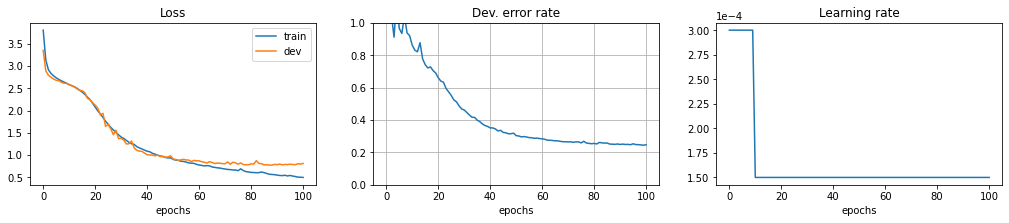

In [13]:
plotLearning("config/default/history.csv")

In [14]:
from torch.autograd import Variable
import torch.utils.data

batch_size = cfg['train']['batch_size']
input_dim = 28 * 28
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for step, (xs, xlens, ys) in enumerate(train_loader):
    xs = xs.to(device) 
    ys = ys.to(device)
    #inputs = Variable(data.resize_(batch_size, input_dim))

modeled_data = model(xs, xlens, ys) #model(inputs)
print("modeled_data (loss) = ", modeled_data)
print("xs = ", xs)
print("ys = ", ys)
#model_data = modeled_data[0].reshape(batch_size, input_dim)
#print(input_data)        
#plt.imshow(model_data[0].detach().numpy().reshape(28, 28), cmap='gray')
#plt.show(block=True)

modeled_data (loss) =  tensor(0.3085, device='cuda:0', grad_fn=<NllLossBackward>)
xs =  tensor([[[-15.9424, -15.9424, -15.9424,  ..., -11.1206, -11.6061, -11.7099],
         [-15.9424, -15.9424, -15.9424,  ..., -12.1963, -11.8304, -10.6997],
         [-15.9424, -15.9424, -15.9424,  ..., -11.0404, -11.3361, -11.6325],
         ...,
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],

        [[-15.9424, -15.9424, -15.9424,  ..., -10.7015, -10.5714, -10.5453],
         [-15.9424, -15.9424, -15.9424,  ..., -10.9500,  -9.8696, -10.3210],
         [-15.9424, -15.9424, -15.9424,  ..., -10.8692, -10.7056, -10.4309],
         ...,
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0

### Eval

In [15]:
# Restore checkpoint
info = torch.load("config/default/best.pth")
split = 'test'
print ("Dev. error rate of checkpoint: %.4f @epoch: %d" % (info['dev_error'], info['epoch']))
    
# Build model
tokenizer = torch.load('tokenizer.pth')
model = VAE(len(tokenizer.vocab),
                            hidden_size=cfg['model']['hidden_size'],
                            encoder_layers=cfg['model']['encoder_layers'],
                            decoder_layers=cfg['model']['decoder_layers'])
model.load_state_dict(info['weights'])
model.eval() 
model.cuda()

# Evaluate
error = eval_utils.get_error(train_loader, model)
print ("Error rate on %s set = %.4f" % (split, error))

Dev. error rate of checkpoint: 0.2442 @epoch: 99
Init VAE
Calculating error rate ... (#batch: 58/58)
Error rate on test set = 0.1238


### Plot Training & Eval time

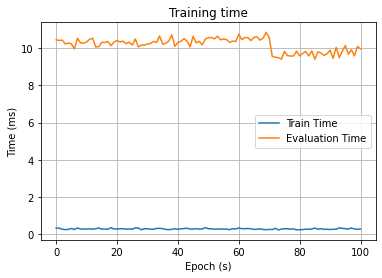

In [16]:
# Note that using plt.subplots below is equivalent to using
# fig = plt.figure() and then ax = fig.add_subplot(111)
fig, ax = plt.subplots()

#now create y values for the second plot
y = train_epoch_durations
#calculate the values for the Gaussian curve
x = np.arange(len(train_epoch_durations))
#plot the Gaussian curve
ax.plot(x, y, label = "Train Time")

ax.set(xlabel='Epoch (s)', ylabel='Time (ms)',
       title='Training time')

xe = np.arange(len(eval_epoch_durations))
ye = eval_epoch_durations
#plot sine wave
ax.plot(xe, ye, label = "Evaluation Time")

ax.grid()

#show the legend
plt.legend()
plt.show()

#### Inference auxiliary method

In [17]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import argparse


def showAttention(predictions, attentions):
    output_words = predictions.split()
    # Set up figure with colorbar
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='bone')
    fig.colorbar(cax)

    ax.set_yticklabels([''] + output_words)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

### Inference

Predict:
ih tcl w ih z q ao kcl k w ix dcl pau v eh r iy q ao kcl k w axr dcl h#
Ground-truth:
h# ih tcl w ix z q ao kcl k w ax dcl pau v eh r iy q ao kcl k w axr dcl h#



/home/jay/.conda/envs/jay/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


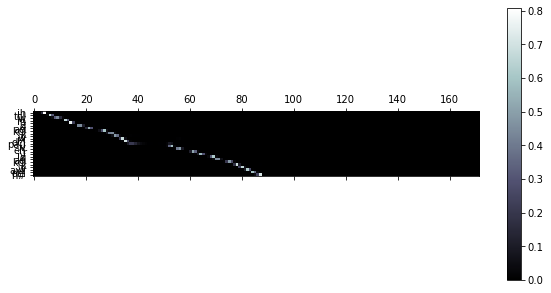

Predict:
q ow n l iy dh ix bcl b eh s tcl t pcl p l ey er z ix n dcl jh oy pcl p aa pcl p iy l eh r ix dx iy h#
Ground-truth:
h# q ow n l iy dh ix bcl b eh s tcl t pcl p l ey er z ix n dcl jh oy pcl p aa pcl p y ix l eh r ih dx iy h#



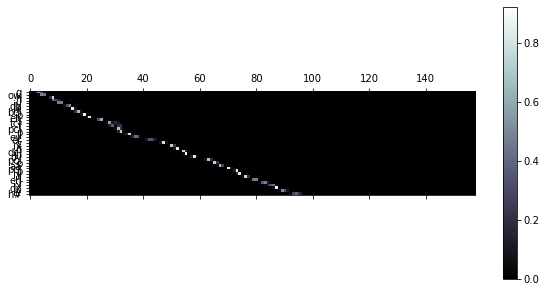

Predict:
q ay q ay dx ah m ay z q ao l ax kcl k aw n tcl s en m ay q ey dcl jh en tcl s iy h#
Ground-truth:
h# q ay q ay dx ah m ay z q ao l ax kcl k aw n tcl s en m ay q ey dcl jh en tcl t s iy h#



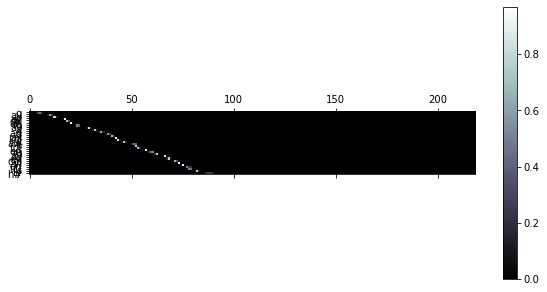

Predict:
ix s ih m pcl p aa s bcl b el ax dcl d iy l w ax gcl g y aa kcl k axr s iy h#
Ground-truth:
h# ix s ih m pcl p aa s bcl b el ax dcl d iy l w ax bcl y axr aa kcl k axr s iy h#



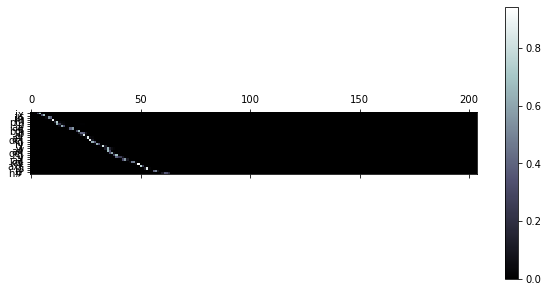

Predict:
dh iy pcl p r iy v iy ih s pcl p iy kcl k ah pcl p axr z eh n eh dcl d ix q ae m bcl b ih gcl g y uw ax s epi r ih z ah l tcl t s h#
Ground-truth:
h# dh iy pcl p r iy v iy ih s pcl p iy kcl k ah pcl p axr z eh n eh dcl d ix q ae m bcl b ih gcl g y ux w ah s epi r ih z ah l tcl t s h#



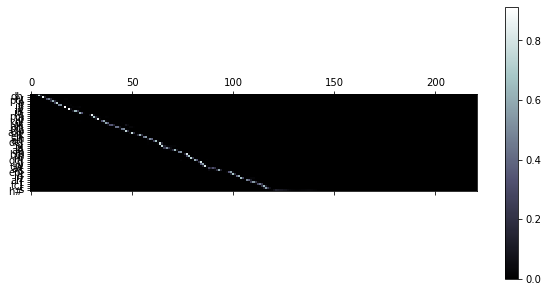

Predict:
ay r ix s tcl t l ih ng kcl k s dh ih z z uw hv ae z ix l eh v ix n s pcl p ae nx iy sh z iy bcl b r ix s h#
Ground-truth:
h# ay r ih s th iy n kcl k s dh ih s z uw hv ae z ix l eh v ix n s pcl p ae nx ih sh z iy bcl b r ax s h#



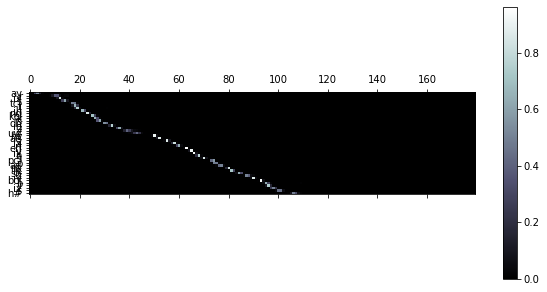

Predict:
dh ix tcl t aa dcl d w er f aw n dcl d ah kcl k l ae m sh eh l n axr dh ix kcl k ae m pcl p s ay tcl t h#
Ground-truth:
h# dh ix tcl t aa dcl d l axr f aw n dcl d ah kcl k l ae m sh eh l n ix r dh ix kcl k ae m pcl p s ay tcl t h#



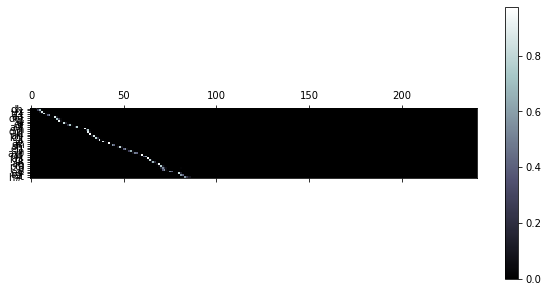

Predict:
b r ah sh f ay er z axr kcl k aa m ax n ix n dh ix dcl jh r ay q ah n dcl d axr bcl b r ah sh ax v n ax v ae dx ax h#
Ground-truth:
h# b r ah sh f ay er z ax r kcl k aa m ax n ix n dh ix dcl d r ay q ah n d axr bcl b r ah sh ax v n ax v ae dx ax h#



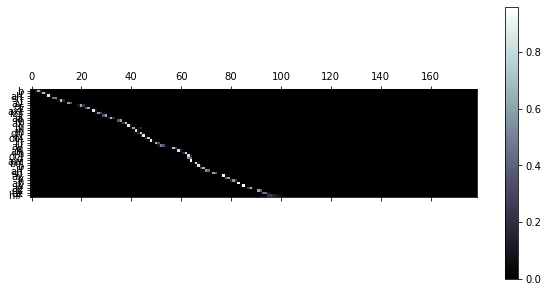

Predict:
g uh tcl ch ey n jh axr sh ux z bcl b ax f ao y ux tcl t axr n er aw n dcl d h#
Ground-truth:
h# g uh tcl ch ey n jh axr sh ux z bcl b ax f ao y ux tcl t axr n er aw n dcl d h#



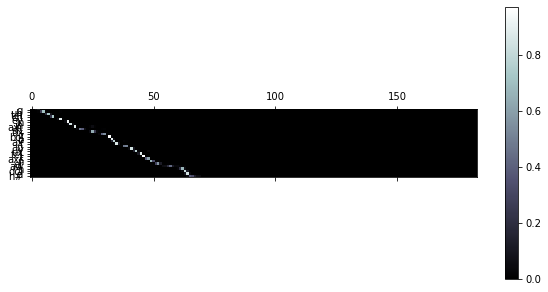

Predict:
sh iy y ux z ih z bcl b ow th epi n ey m z ih nx er tcl ch ey n dcl jh ix bcl b l iy h#
Ground-truth:
h# sh iy ux z ix z bcl b ow th epi n ey m z ih nx er tcl ch ey n dcl jh ix bcl b l iy h#



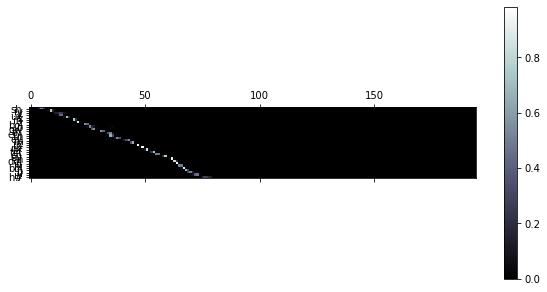

Predict:
hh uw tcl t ih kcl dh ix kcl k ay ae kcl k dcl d aw n dh ax bcl b ay y ux h#
Ground-truth:
h# hh uw tcl t uh kcl k dh ix kcl k ay ae kcl k dcl d aw n dh ax bcl b ay y ux h#



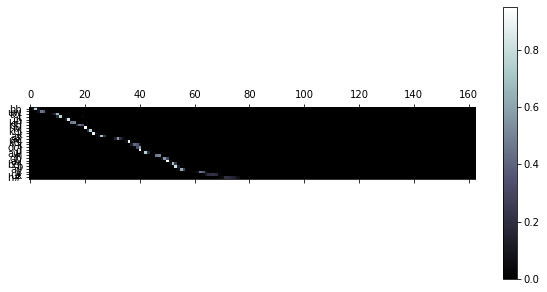

Predict:
hh ux tcl t uh kcl t ix kcl k ay ae kcl t eh n dh ax bcl b ay ux h#
Ground-truth:
h# hh ux tcl t uh kcl k epi dh ix kcl k ay ae kcl d aw n dh ax bcl b ay ux hh h#



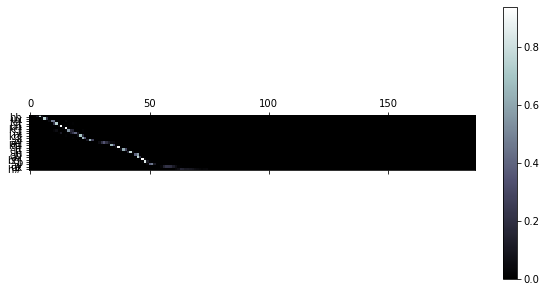

Predict:
eh n ih dcl d ow l dcl m ey l bcl b ae bcl b uw n z tcl t iy th ix n aa tcl s uh dx ix bcl b el f r iy dx ix ng sh eh l f ix sh h#
Ground-truth:
h# eh n ih dcl d ah l tcl m ey l bcl b ae bcl b uw n z tcl t iy th axr n aa tcl s uh dx ax bcl b el f axr iy dx ix ng epi sh eh l f ix sh h#



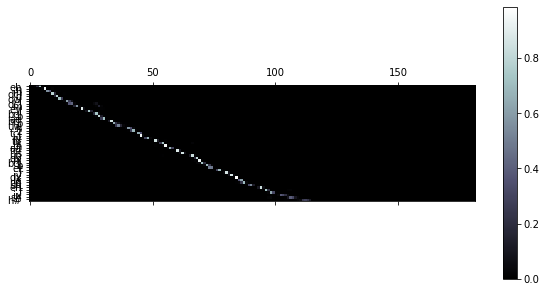

Predict:
q ay dcl jh uh s aa dcl jh ih m n ih r dh ix n uw aa r kcl k iy l ay dcl jh kcl k el m iy z iy ix m h#
Ground-truth:
h# q ay dcl jh uh s ao dcl jh ih m n ih r dh ix n uw aa r kcl k iy l aa dcl jh kcl k el m y ux z iy ix m h#



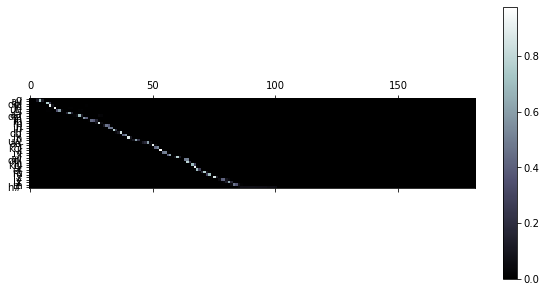

Predict:
v iy eh tcl m ix n iy z kcl k ux z iy n q ih z pau eh kcl s kcl k w ih z ix tcl h#
Ground-truth:
h# v iy eh tcl m ax n iy z kcl k ux z iy n q ih z pau eh kcl s kcl k w ih z ix tcl h#



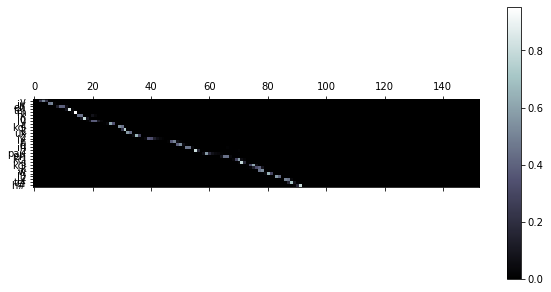

Predict:
hh iy q ey tcl f ao r eh kcl s tcl t axr q eh gcl z f axr bcl b r eh kcl f ax s tcl t h#
Ground-truth:
h# hh iy q ey tcl f ao r eh kcl s tcl t r ax q eh gcl z f axr bcl b r eh kcl f ix s tcl t h#



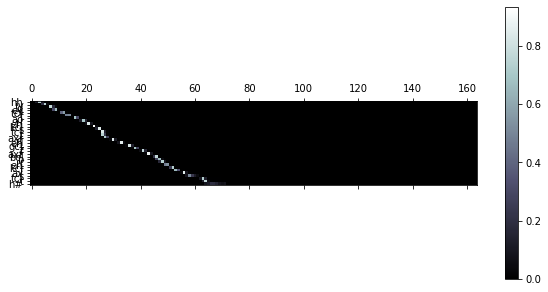

Predict:
m ow s tcl jh y ao ng r ay z q er l iy q eh v r ix m ao r nx ix ng h#
Ground-truth:
h# m ow s tcl t y ah ng r ay z pau er l iy q eh v r ix m ao r nx ih ng h#



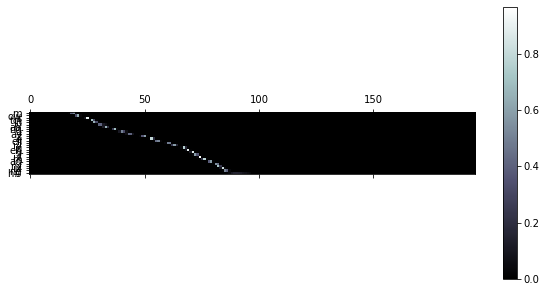

Predict:
d uw q ey tcl t ih pcl p ix kcl k el f aa r m er z gcl g r ow q ow tcl t s h#
Ground-truth:
h# d ux q ey tcl t ih pcl p ix kcl k el f aa r m axr z gcl g r ow q ow tcl t s h#



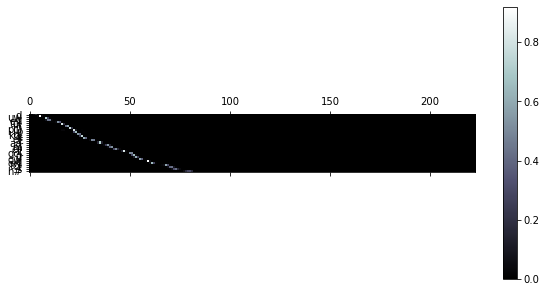

Predict:
dh ix kcl k en tcl t ih n y uw iy ng m aa dx axr n ix z ey sh ix n q ax v dh iy z f ao r s ix z ix z ix kcl k aa s l iy bcl b ix tcl n eh s ix s eh r iy pcl p r aa s eh s h#
Ground-truth:
h# dh iy kcl k en tcl t ih n y uw iy ng m aa dx er n ih z ey sh ix n q ax v dh iy z f ao r s eh z ix z ey kcl k ao s l iy bcl b ix q n eh s ax-h s eh r iy pcl p r aa s eh s h#



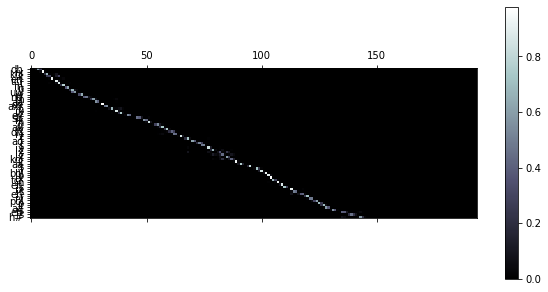

Predict:
b r ah sh f ay axr z ax kcl k aa m ax n ax n dh ax dcl d r ay ah n dh ix bcl b r ah sh ax v n ax v ay dx ax h#
Ground-truth:
h# b r ah sh f ay axr z ax kcl k aa m ax n ax n dh ax dcl d r ay ah n dcl d ax bcl b r ah sh ax v n ax v aa dx ax h#



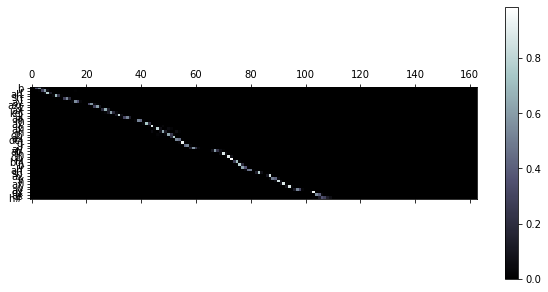

Predict:
y ux m ah s tcl t ix kcl k s pcl p l ih s ix q l iy dcl d ax l iy kcl f ay l z h#
Ground-truth:
h# y ix m ah s tcl t ax kcl k s pcl p l ih s ix q l iy dcl d ax l iy tcl f ay l z h#



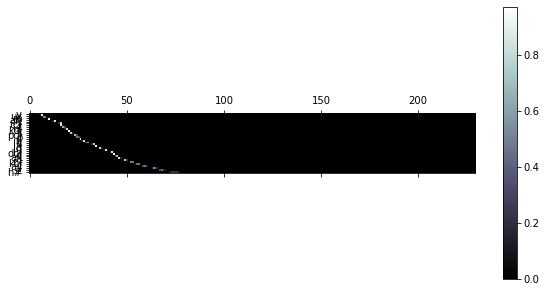

Predict:
w iy v gcl g ah tcl p l eh n iy ix v tcl t ay m dcl d ix th ih ng kcl k ax bcl b aw tcl dh ae tcl h#
Ground-truth:
h# w iy v gcl g ah tcl p l eh n iy ix v tcl t ay m dcl d ix th ih ng kcl k ax bcl b aw tcl dh ae tcl h#



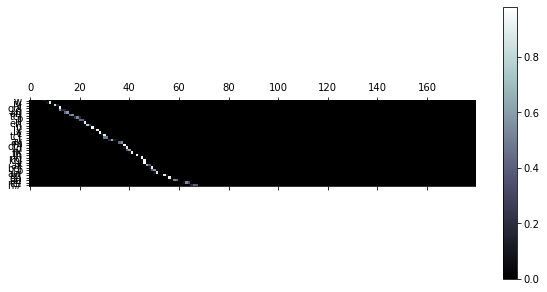

Predict:
d ux dcl d ey ah l aw q ey th iy ix s ix n tcl ch er tcl ch h#
Ground-truth:
h# d ux dh ey ah l aw q ey th iy ix s ix n tcl ch er tcl ch h#



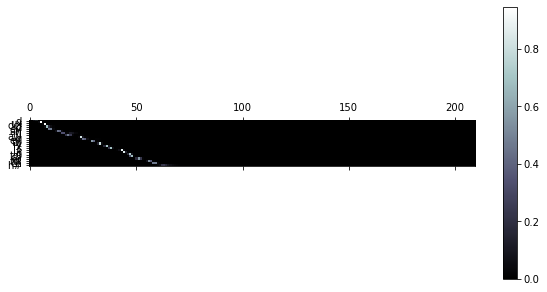

Predict:
ey l ow n s tcl t aa r sh ow n q ih n dh ih q er l iy q iy v n ix ng s kcl k ay h#
Ground-truth:
h# ey l ow n s tcl t aa r sh ow n q ix n dh iy q er l iy q iy v n iy ng s kcl k ay h#



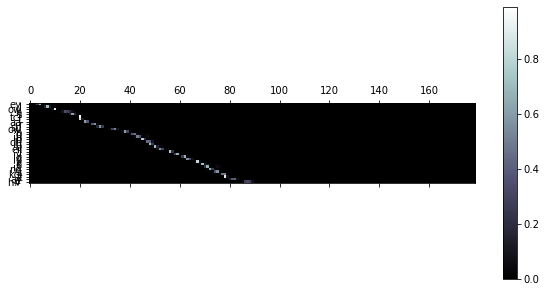

Predict:
b ay ix ng ah th ah r ow bcl b r eh dcl d hh ao r s axr kcl k w ay axr z q ih n tcl t uw ih sh ix n eh n eh kcl k s pcl p axr tcl t iy s h#
Ground-truth:
h# b ay ih ng ah th ah r ow bcl b r eh dcl d hh ao r s r ax kcl k w ay axr z q ih n tcl t uw ih sh ix n eh n eh kcl k s pcl p axr tcl t iy s h#



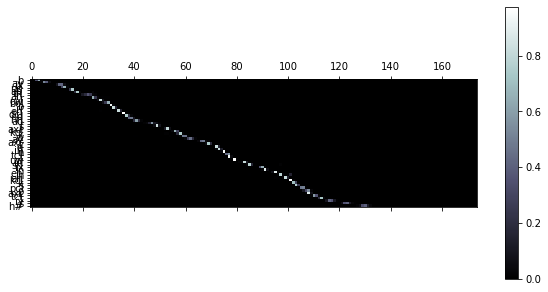

Predict:
dh ax bcl b l uw r aa gcl g w ah s ax s pcl p ih sh ix s l iy bcl b r ay tcl q ix n ux h#
Ground-truth:
h# dh ax bcl b l uw r ah gcl g w ah s ah s pcl p ih sh ix s l iy bcl b r ay tcl q ax n ux h#



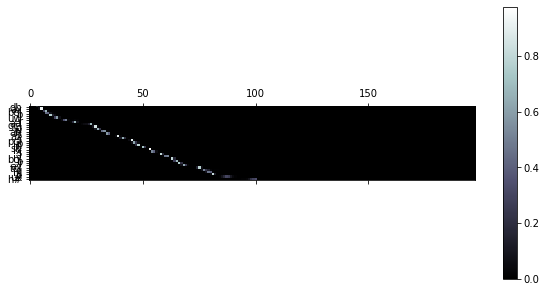

Predict:
y ux l ah kcl k iy kcl k eh dcl d s hh iy s eh dcl h#
Ground-truth:
h# y ux l ah kcl k ix kcl k ih dcl s hh iy s eh dcl h#



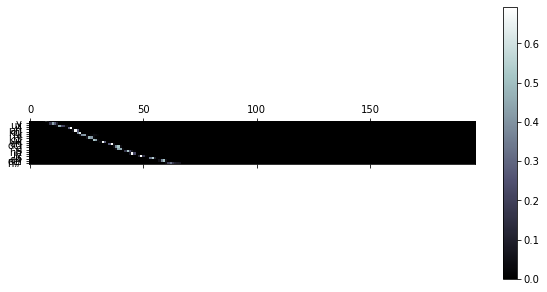

Predict:
q ae f tcl t er n ah dh axr l ao ng pcl p ao z iy q ae s tcl t pau hh aw m ix nx iy pcl p iy pcl p el n ow hv uw dh ey ao r h#
Ground-truth:
h# q ae f tcl t er n ah dh axr l ao ng pcl p ao z hv iy q ae s kcl k dcl d pau hh aw m ix n iy pcl p iy pcl p el n ow hv uw dh ey q aa axr h#



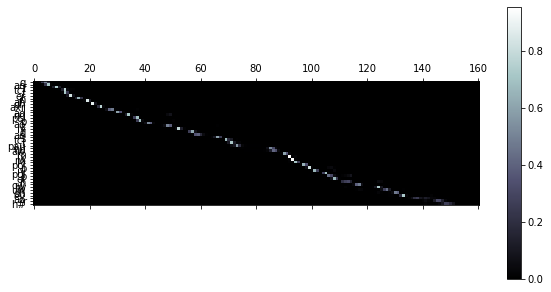

Predict:
w eh l m aw w iy hv ae v tcl t ux bcl b ih gcl g z iy ix dx axr z h#
Ground-truth:
h# w eh l pau n aw w iy hv ae v tcl t ux bcl b ih gcl g th iy ix dx axr z h#



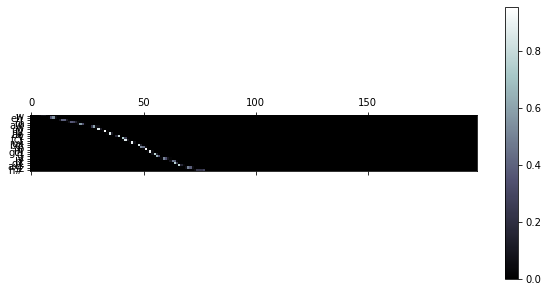

Predict:
dh ix s pcl p iy tcl ch s ix m pcl p ow z iy ix m pau m ay tcl b iy gcl g ih n m ah n dcl d ey h#
Ground-truth:
h# dh ix s pcl p iy tcl ch s ix m pcl p ow z iy ix m pau m ay tcl b iy gcl g ix n m ah n dcl d ey h#



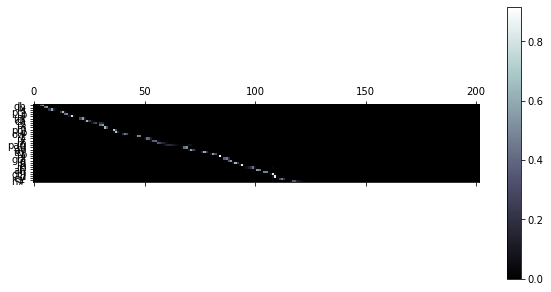

Predict:
w ay er y ux tcl t r ay n dcl d ax w er ix m iy h#
Ground-truth:
h# hh w ay er y ux tcl t r ay n dcl d ax w er ix m ix h#



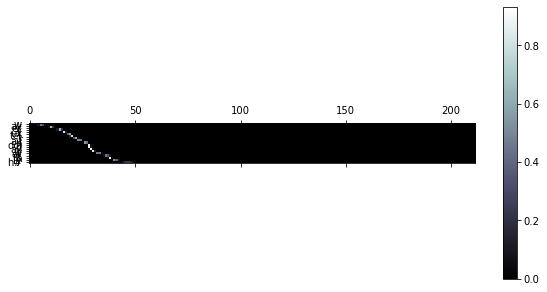

Predict:
dh ax s er pcl p l ah sh ux z w axr s ow l dcl eh tcl t ix dcl d ih s kcl k aw n pcl p r ay s h#
Ground-truth:
h# dh ix s er pcl p l ah sh ux z w er s ow l dcl ae tcl t ix dcl d ih s kcl k aw m pcl p r ay s h#



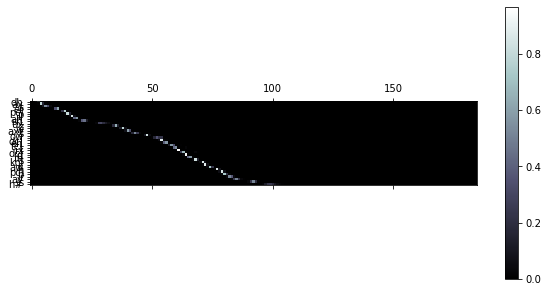

Predict:
sh iy ae s epi w ax th axr r eh pcl p axr tcl t ao r iy el gcl g l iy n ix nx axr ay h#
Ground-truth:
h# sh iy ae s kcl w ax th axr r eh pcl p axr tcl t ao r ix el gcl g l iy m ix nx axr ay h#



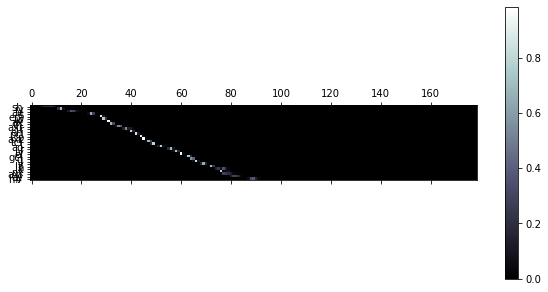

Predict:
hh aw q ah nx axr m aa m ah m h#
Ground-truth:
h# q aa q aa nx axr m aa m aa m h#



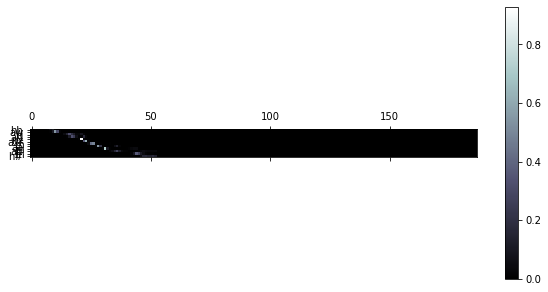

Predict:
dh ix n ux s ix bcl b er bcl b ax n ay tcl s w er tcl t hh aa r dcl d q ao ng r iy f er bcl b axr sh iy ng dh eh r q ow l dcl d ax hv ow ix n h#
Ground-truth:
h# dh ih n ux s ix bcl b er bcl b ah n ay tcl t s w er kcl t hh aa r dcl d ao n r iy f er bcl b r ix sh iy ng dh ih er ow l dcl d ah hh ah ix m ax h#



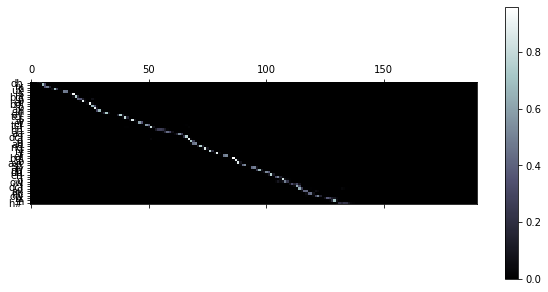

Predict:
f l ay ix ng s tcl t ae m bcl b ay kcl k ix n bcl b iy pcl p r ae kcl t kcl k el q ih f y ux w ao tcl t ix s ey v m ah n iy h#
Ground-truth:
h# f l ay ix ng s tcl t ae m bcl b aa kcl k ix n bcl b iy pcl p r ae kcl t ax-h kcl k el q ix f y ux w ao n tcl t ix s ey v epi m ah n iy h#



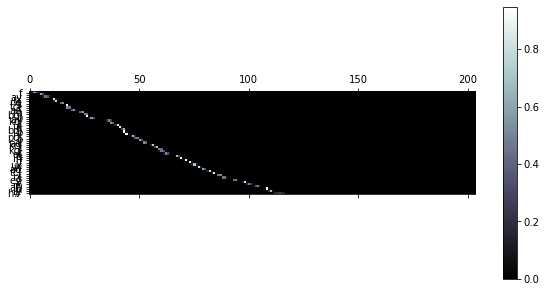

Predict:
dh ix kcl k ay ow dx iy pau b aa bcl k ae tcl q ix n hv ay iy n ah q aa r w ay l dcl d q ae nx ax m el z h#
Ground-truth:
h# dh ix kcl k ay ow dx iy pau b aa bcl k ae q ix n hv ay iy n ah q aa r w ay l dcl d q ae nx ax m el z h#



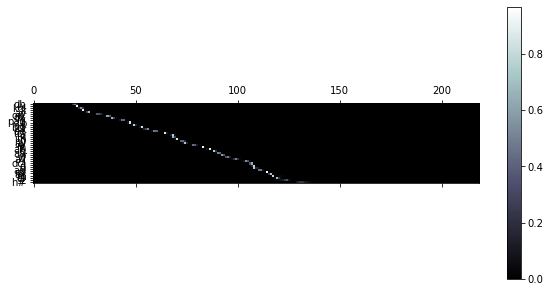

Predict:
q ix n tcl t ux kcl k ey s ih z pau q eh r pcl p l ey n z q ow n l iy w er eh n dcl d ix kcl k ey dx ix dcl h#
Ground-truth:
h# q ix n tcl t ux kcl k ey s ih z pau q eh r pcl p l ey n z q ow n l iy w axr ih n dcl d ix kcl k ey dx ix dcl h#



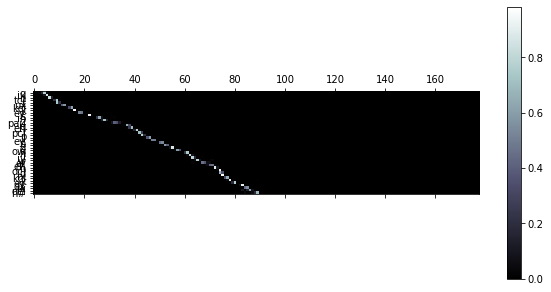

Predict:
d ih dcl d ae dcl d ux ae kcl k ix dcl d eh m ix kcl b ih dx ix ng h#
Ground-truth:
h# d ih dcl d ae dcl d ux ae kcl k ix dcl d eh m ix kcl b ih dx ih ng h#



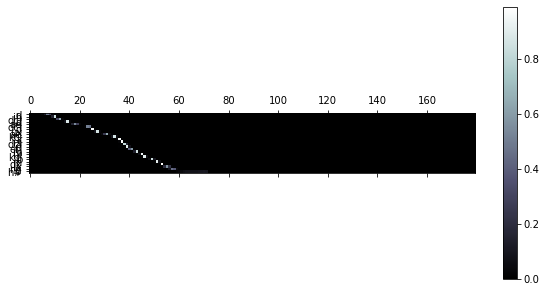

Predict:
q ah hv y ux dcl jh tcl t ae pcl p ix s tcl t r iy hv ah ng ih n hv axr hv ao l w ey h#
Ground-truth:
h# q ah hv y ux dcl jh tcl t ae pcl p ax s tcl t r iy hv ah ng ix n hv axr hv ao l w ey h#



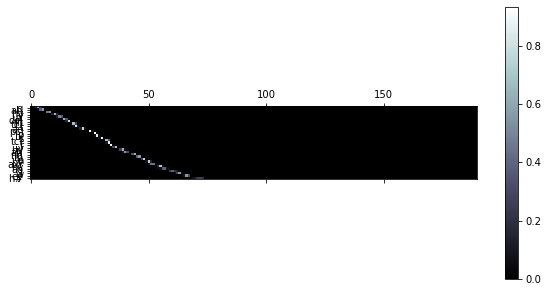

Predict:
b er th bcl b ey pcl p ao r dx iy z hh ae v kcl k ah pcl k ey kcl k s eh n ay s kcl k r iy m h#
Ground-truth:
h# b er th dcl d ey pcl p aa r dx iy z hh ae v kcl k ah pcl k ey kcl k s ih n ay s kcl k r iy m h#



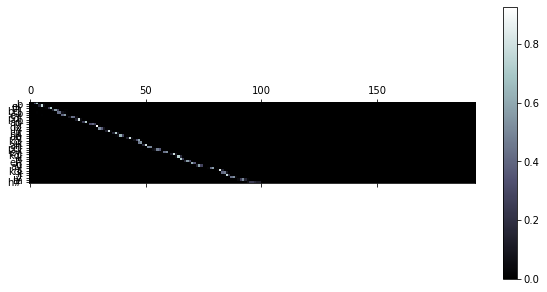

Predict:
k r ih kcl k ih dcl q q ow v axr l ae pcl p iy ng pau t w ih s tcl t ih dx axr w ay dcl d l iy s pcl p ey s tcl t iy th h#
Ground-truth:
h# k r uh kcl k ih dcl q pau q ow v axr l ae pcl p ih ng pau t w ih s tcl t ih dx er w ay dcl d l iy s pcl p ey s tcl t iy th h#



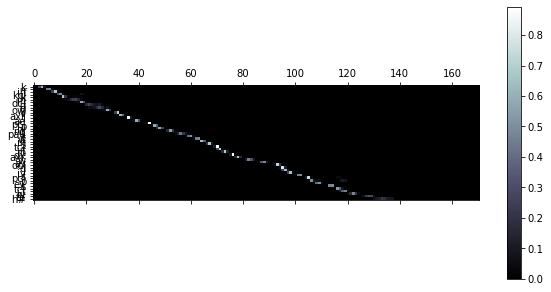

Predict:
f ao r ih m ae n q ah v hh ih z epi m ae s hh iy w ix z kcl k y er ix s epi l iy sh ao ix tcl h#
Ground-truth:
h# f ao r ey m ae n q ah v hh ih z epi m ae s hh iy w ix z kcl k y er ix s epi l iy sh ao ix tcl h#



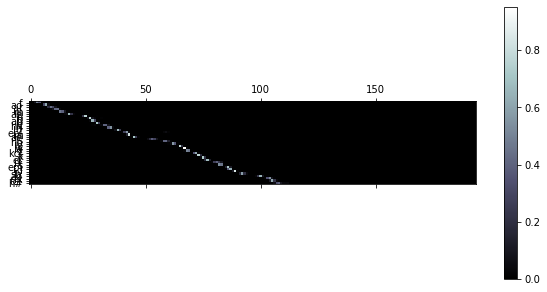

Predict:
sh ax-h f aw n d er s eh l pcl p ey bcl el tcl t ax s ih ng ih nx iy r ow l pau eh nx ih nx iy s ao ng w ix tcl ch tcl t r ah kcl k axr f ae n tcl s iy h#
Ground-truth:
h# sh ax-h f aw n hv er s eh l f q ey bcl el tcl t ax s ih ng ih n iy r ow l pau eh nx ih nx iy s ao ng w ix tcl ch tcl t r ah kcl k axr f ae n tcl s iy h#



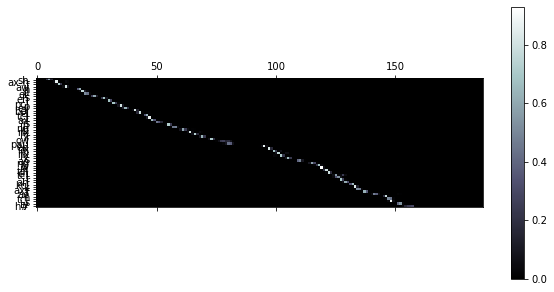

Predict:
q ix tcl s hh aa r tcl t ix tcl t eh l ax n ax r ih dcl jh ix nx ax l f axr m ax f ao r dcl jh axr iy h#
Ground-truth:
h# q ix tcl s hh aa r dcl t ix tcl t eh l ax n ax r ih dcl jh ix nx ax l epi f axr m ax f ao r dcl jh axr ix h#



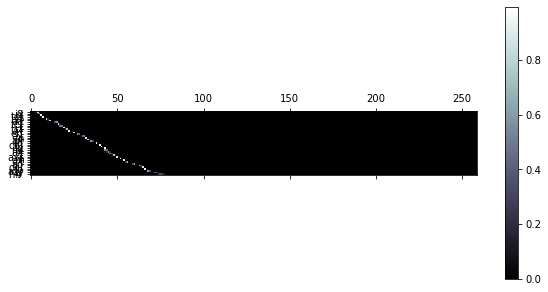

Predict:
dh ey ah n dcl d er s tcl t uh dcl en tcl t iy z epi m iy ih bcl b ih tcl q ax v aa dx ix tcl h#
Ground-truth:
h# dh ey ah n dcl d er s tcl t uh dcl en tcl t iy z dcl m iy ix bcl b ih q n ax bcl b aa dx ax tcl h#



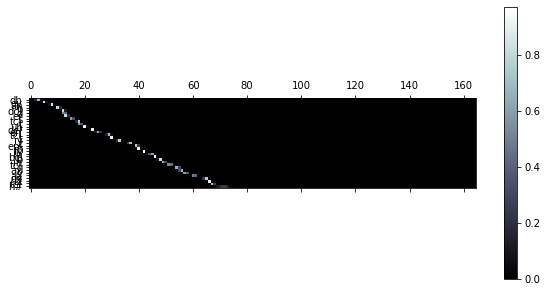

Predict:
q ay tcl t uh kcl k hh axr w er dcl f ao r ix tcl b ah dx ix sh ix r eh l iy gcl g ow ng w ih th y ux h#
Ground-truth:
h# q ay tcl t uh kcl k hh axr w er dcl f ao r ix q pau b ah dx ix sh ix r ih l ix gcl g ow n w ih th y ux h#



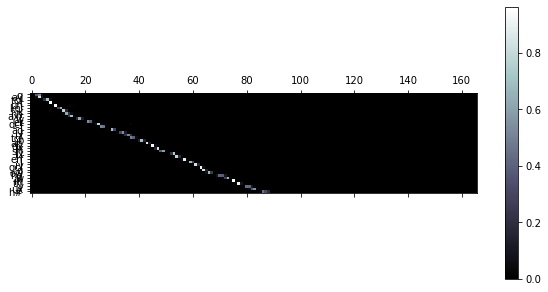

Predict:
q aw axr s ix kcl k s eh s axr z epi w el hv ae v ix n iy z iy axr tcl t ae s kcl k h#
Ground-truth:
h# q aw axr s ix kcl k s eh s axr z epi w el hh ae v ix n iy z iy axr tcl t ae epi s kcl k h#



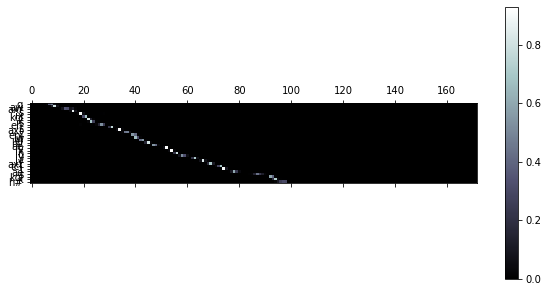

Predict:
dh ax r ow z kcl k ow s aa dcl s bcl b eh l dcl d s epi w iy tcl h#
Ground-truth:
h# dh ax r ow z kcl k uh s aa dcl s epi m eh l dcl s epi w iy tcl t h#



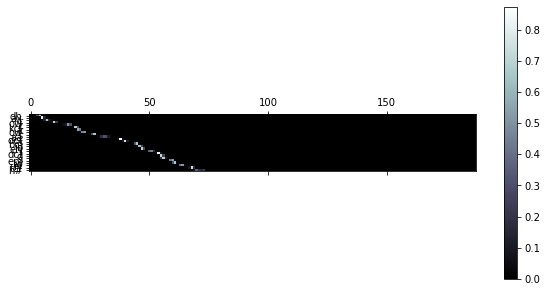

Predict:
dh ix dcl d ay gcl n ow s ix s epi w ah z dcl d ix s kcl k er dcl jh ix ng pau hh aw eh v axr pau hh iy w ix z n aa dx ow v axr l iy w er iy dcl d h#
Ground-truth:
h# dh ix dcl d ay gcl n ow s ix s epi w ah z dcl d ix s kcl k er ix dcl jh ix ng pau hh aw eh v axr pau hh iy w uh z n aa dx ow v axr l iy w er ix dcl d h#



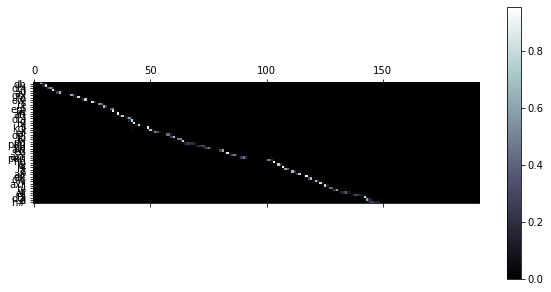

Predict:
ch ih l dx ah n kcl k ae n pau k en s ux m ey v r ux tcl t kcl k ae n iy z ix n w ah n s ih dx ix ng h#
Ground-truth:
h# ch ih l dx r ih n kcl k ae n pau k en s uw m eh nx iy f r ux tcl t kcl k ae n iy z ix n w ah n s ih dx iy n h#



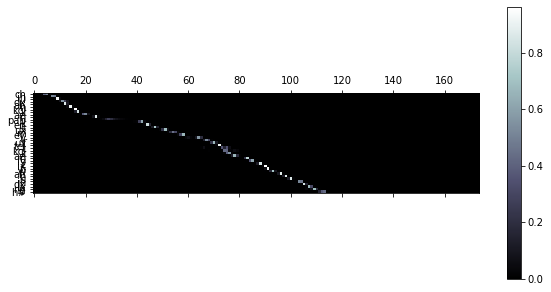

Predict:
dh iy ae v ax l ae n tcl ch tcl t r ih gcl g er dx ey m ay nx er axr z kcl k w ey kcl k h#
Ground-truth:
h# dh iy ae v ax l ae n tcl ch tcl t r ih gcl g axr dcl d ey m ay nx er er th kcl k w ey kcl k h#



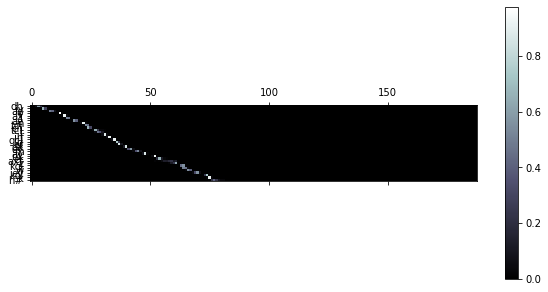

Predict:
t r ay dx axr r iy kcl k ao l dh iy ix v ae n s epi en kcl k r ah nx ax l aa dcl jh kcl k el ow dx axr h#
Ground-truth:
h# t r ay dx ix r iy kcl k ao l dh iy ix v eh n tcl s epi en kcl k r aa nx ax l aa dcl jh ax-h kcl k el ao r dcl d axr h#



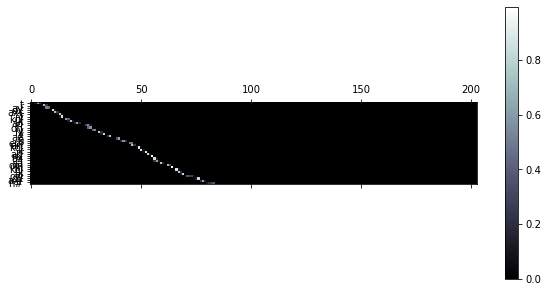

Predict:
ih w ix z epi m ah s kcl k ux l er bcl b ah dx ix q w ah z ah n s ax m eh tcl t axr kcl k el h#
Ground-truth:
h# ih w ix z epi m ah s kcl k ux l er bcl b ax dx ix q w ah z ax n tcl s ax m eh tcl t axr kcl k el h#



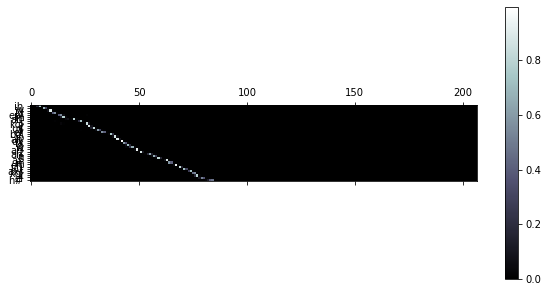

Predict:
k r eh kcl t q eh kcl k s ix kcl k ux sh en ah v m ay ix n s tcl t r ah kcl sh en z ix z kcl k r ux sh el h#
Ground-truth:
h# k r eh kcl t q eh kcl k s ix kcl k y ux sh en ax v m ay ix n s tcl t r ah kcl sh en z ix z kcl k r ux sh el h#



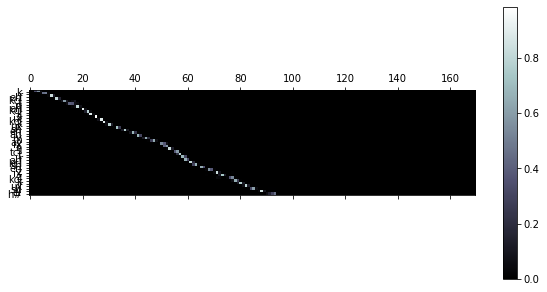

Predict:
q ey tcl t ux th pcl p ey s tcl t ux bcl s ix bcl b iy s kcl k w iy z f r em dh ax bcl b aa tcl t ax m h#
Ground-truth:
h# q ey tcl t ux th pcl p ey s tcl t ux bcl sh uh dcl b iy s kcl k w iy z f axr m dh ax bcl b aa tcl t ax m h#



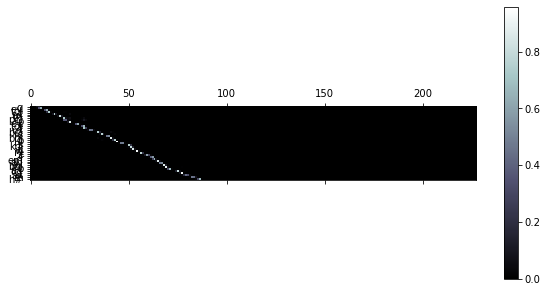

Predict:
jh aa n z bcl b r ah dh axr r iy pcl p ey nx ix dcl dh ix gcl g r aa dcl jh tcl t ao r h#
Ground-truth:
h# jh aa n z bcl b r ah dh axr r iy pcl p ey nx ih dcl dh ax-h gcl g axr aa dcl jh dcl d ao r h#



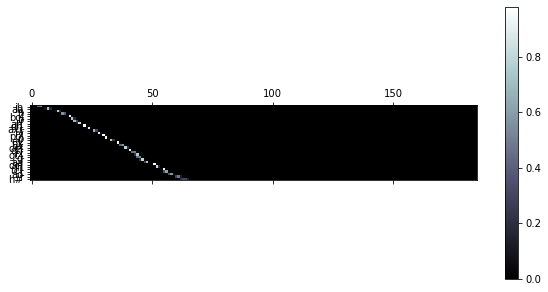

Predict:
k r ih dx ix kcl k el ix kcl k w ih v m iy n iy dcl d z pcl p r aa pcl p axr m eh n tcl t ix n ix n tcl t s h#
Ground-truth:
h# k r ih dx ih kcl k el ax kcl k w ih q m ix n iy dcl d z pcl p r aa pcl p axr m ey n tcl t ix n ix n tcl t s h#



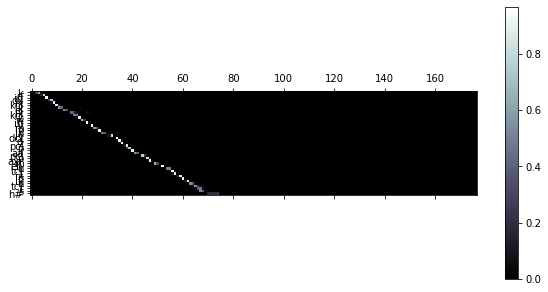

In [18]:
# Inference
with torch.no_grad():
    for (x, xlens, y) in train_loader:
        predictions, attentions = model(x.cuda(), xlens)
        predictions, attentions = predictions[0], attentions[0]
        predictions = tokenizer.decode(predictions)
        attentions = attentions[:len(predictions.split())].cpu().numpy()   # (target_length, source_length)
        ground_truth = tokenizer.decode(y[0])
        print ("Predict:")
        print (predictions)
        print ("Ground-truth:")
        print (ground_truth)
        print ()
        showAttention(predictions, attentions)

In [19]:
epoch = 0
with open('config/default/timing.txt', 'w') as filehandle:
    for (train_epoch_duration, eval_epoch_duration, RMSE) in zip(train_epoch_durations, eval_epoch_durations, RMS):
        msg = '%d, %s, %s, %s \n' % (epoch, train_epoch_duration, eval_epoch_duration, RMSE)
        #print(msg)
        epoch = epoch +1 
        filehandle.write(msg)